In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from PIL import Image
import os

C:\Users\chao_gu\Anaconda3\envs\tensorflow_workshop\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## load pictures

In [2]:
IMAGE_SHAPE = (200,300)

In [3]:
IMAGE_SHAPE_INPUT = (200,300,3)

In [4]:
path = os.getcwd() + '\\house_image\\'

In [5]:
folders = os.listdir(path)

In [6]:
bedrooms = [path+i+'\\'+'bedroom.jpg' for i in folders]
bathrooms = [path+i+'\\'+'bathroom.jpg' for i in folders]
living_rooms = [path+i+'\\'+'living_room.jpg' for i in folders]
kitchens = [path+i+'\\'+'kitchen.jpg' for i in folders]

## build model - VGG

In [7]:
#weight to normalize image pixel value for vgg19 model
RGB_MEAN_PIXELS = np.array([123.68,116.779,103.939]).reshape((1,1,1,3)).astype(np.float32)

In [8]:
import keras

Using TensorFlow backend.


In [9]:
def get_feature_matrix_vgg(path_list):
    image_array = []
    for img in path_list:
        im = Image.open(img)
        im = im.resize(IMAGE_SHAPE[::-1])
        image_array.append(np.array(im))
    image_array = np.array(image_array)
    vgg19 = keras.applications.VGG19(weights='imagenet', include_top=False)
    embedding = []
    for i in image_array:
        img_input = np.expand_dims(i,0)
        keras_output = vgg19.predict(np.flip(img_input-RGB_MEAN_PIXELS,axis = -1))
        embedding.append(keras_output)
    return np.array(embedding)

In [10]:
bedrooms_embedded_vgg = get_feature_matrix_vgg(bedrooms)

In [11]:
bedrooms_embedded_vgg.shape

(118, 1, 6, 9, 512)

## build model - VGG -intermediate layer 

In [12]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.models import Model

vgg has block from 1 to 5

In [13]:
def get_feature_matrix_vgg_block(path_list, layer = 'block4_pool'):
    base_model = VGG19(weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer).output)
    image_array = []
    for img in path_list:
        im = Image.open(img)
        im = im.resize((224,224))
        x = image.img_to_array(im)
        x = preprocess_input(x)
        image_array.append(np.array(x))
    image_array = np.array(image_array)
    embedding = []
    for i in image_array:
        img_input = np.expand_dims(i,0)
        keras_output = model.predict(img_input)
        embedding.append(keras_output)
    return np.array(embedding)

In [14]:
bedrooms_embedded_vgg_block1 = get_feature_matrix_vgg_block(bedrooms, layer = 'block1_pool')
bedrooms_embedded_vgg_block2 = get_feature_matrix_vgg_block(bedrooms, layer = 'block2_pool')
bedrooms_embedded_vgg_block3 = get_feature_matrix_vgg_block(bedrooms, layer = 'block3_pool')
bedrooms_embedded_vgg_block4 = get_feature_matrix_vgg_block(bedrooms, layer = 'block4_pool')
bedrooms_embedded_vgg_block5 = get_feature_matrix_vgg_block(bedrooms, layer = 'block5_pool')

In [15]:
print('block1',bedrooms_embedded_vgg_block1.shape)
print('block2',bedrooms_embedded_vgg_block2.shape)
print('block3',bedrooms_embedded_vgg_block3.shape)
print('block4',bedrooms_embedded_vgg_block4.shape)
print('block5',bedrooms_embedded_vgg_block5.shape)

block1 (118, 1, 112, 112, 64)
block2 (118, 1, 56, 56, 128)
block3 (118, 1, 28, 28, 256)
block4 (118, 1, 14, 14, 512)
block5 (118, 1, 7, 7, 512)


## build model - InceptionResNetV2

In [16]:
IRN = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, 
                                                               weights='imagenet', 
                                                               input_tensor=None, 
                                                               input_shape=IMAGE_SHAPE_INPUT, 
                                                               pooling='max')

In [17]:
def get_feature_matrix_IRN(path_list):
    image_array = []
    for img in path_list:
        im = Image.open(img)
        im = im.resize(IMAGE_SHAPE[::-1])
        image_array.append(np.array(im))
    image_array = np.array(image_array)
    embedding = []
    for i in image_array:
        img_input = np.expand_dims(i,0)
        keras_output = IRN.predict(np.flip(img_input-RGB_MEAN_PIXELS,axis = -1))
        embedding.append(keras_output)
    return np.array(embedding)

In [18]:
bedrooms_embedded_IRN = get_feature_matrix_IRN(bedrooms)

In [19]:
bedrooms_embedded_IRN.shape

(118, 1, 1536)

## calculate image cosine similarity 

In [20]:
from scipy import spatial

In [21]:
def similarity_matrix(image_embedded):
    n = image_embedded.shape[0]
    similarity_mat = np.zeros((n,n))
    for i in range(n):
        img_i = image_embedded[i].flatten()
        for j in range(n):
            img_j = image_embedded[j].flatten()
            result = 1-spatial.distance.cosine(img_i,img_j)
            similarity_mat[i][j] = result
    return similarity_mat

The function below is to show the first k similar room picture

In [22]:
def similar_img(img_id, sim_mat, img_set, num_result = 1, show_sim = False):
    query = Image.fromarray(np.uint8(img_set[img_id]))
    sim_array = sim_mat[img_id]
    sim_id = np.flip(np.argsort(sim_array),axis = 0)
    target_id = sim_id[1:num_result+1]
    plt.figure(figsize=(40,40))
    ax = plt.subplot(1, num_result, 1)
    plt.imshow(query)
    i = 1
    plt.figure(figsize=(40,40))
    for _id in target_id:
        target = Image.fromarray(np.uint8(img_set[_id]))
        ax = plt.subplot(1, num_result, i)
        if show_sim == True:
            ax.set_xlabel('{} : {}'.format(_id,np.round(sim_array[_id],5)))
        i += 1
        plt.imshow(target)
        
    return

The function below is to show the comparison between different result from different architecture

In [77]:
def similar_img_comparison(img_id, sim_mat_set, img_set, show_sim = False):
    n = len(sim_mat_set.keys())
    
    query = Image.fromarray(np.uint8(img_set[img_id]))
    plt.figure(figsize=(40,40))
    ax = plt.subplot(1,n,1)
    plt.imshow(query)
    
    comparison = {}
    for sim_mat_name,sim_mat in sim_mat_set.items():
        sim_array = sim_mat[img_id]
        sim_id = np.flip(np.argsort(sim_array),axis = 0)
        target_id = sim_id[1]
        comparison[sim_mat_name] = target_id
        
    
    col = 4
    if n%2 == 0:
        row = n/2
    else:
        row = n//2 + 1
        
    i = 1
    plt.figure(figsize=(30,30))
    for name,value in comparison.items():
        target = Image.fromarray(np.uint8(img_set[value]))
        ax = plt.subplot(row, col, i//col*col+i%col)
        if show_sim == True:
            ax.set_xlabel('{} : {} : {}'.format(name,value,np.round(sim_array[value],5)), fontsize = 30)
        i += 1
        plt.imshow(target)
        ax = plt.subplot(row,col, i//col*col+i%col)
        plt.hist(sim_mat_set[name][img_id], bins = 100)
        i += 1
    return

## Comparison 

In [24]:
def image_process(path_list):
    image_array = []
    for img in path_list:
        im = Image.open(img)
        im = im.resize(IMAGE_SHAPE[::-1])
        image_array.append(np.array(im))
    return np.array(image_array)

In [25]:
bedrooms_viz = image_process(bedrooms)

In [26]:
import random

In [27]:
random.seed(32)

In [28]:
selection = random.choices(range(0,120),k=5)

In [29]:
bedrooms_sim_mat_vgg = similarity_matrix(bedrooms_embedded_vgg)
bedrooms_sim_mat_IRN = similarity_matrix(bedrooms_embedded_IRN)
bedrooms_sim_mat_vgg_block1 = similarity_matrix(bedrooms_embedded_vgg_block1)
bedrooms_sim_mat_vgg_block2 = similarity_matrix(bedrooms_embedded_vgg_block2)
bedrooms_sim_mat_vgg_block3 = similarity_matrix(bedrooms_embedded_vgg_block3)
bedrooms_sim_mat_vgg_block4 = similarity_matrix(bedrooms_embedded_vgg_block4)
bedrooms_sim_mat_vgg_block5 = similarity_matrix(bedrooms_embedded_vgg_block5)

In [30]:
comparison_set = {"VGG":bedrooms_sim_mat_vgg,
                 "IRN": bedrooms_sim_mat_IRN,
                 "BLOCK1" : bedrooms_sim_mat_vgg_block1,
                 "BLOCK2" : bedrooms_sim_mat_vgg_block2,
                 "BLOCK3" : bedrooms_sim_mat_vgg_block3,
                 "BLOCK4" : bedrooms_sim_mat_vgg_block4,
                 "BLOCK5" : bedrooms_sim_mat_vgg_block5,}

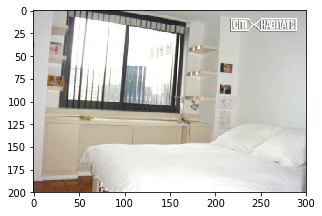

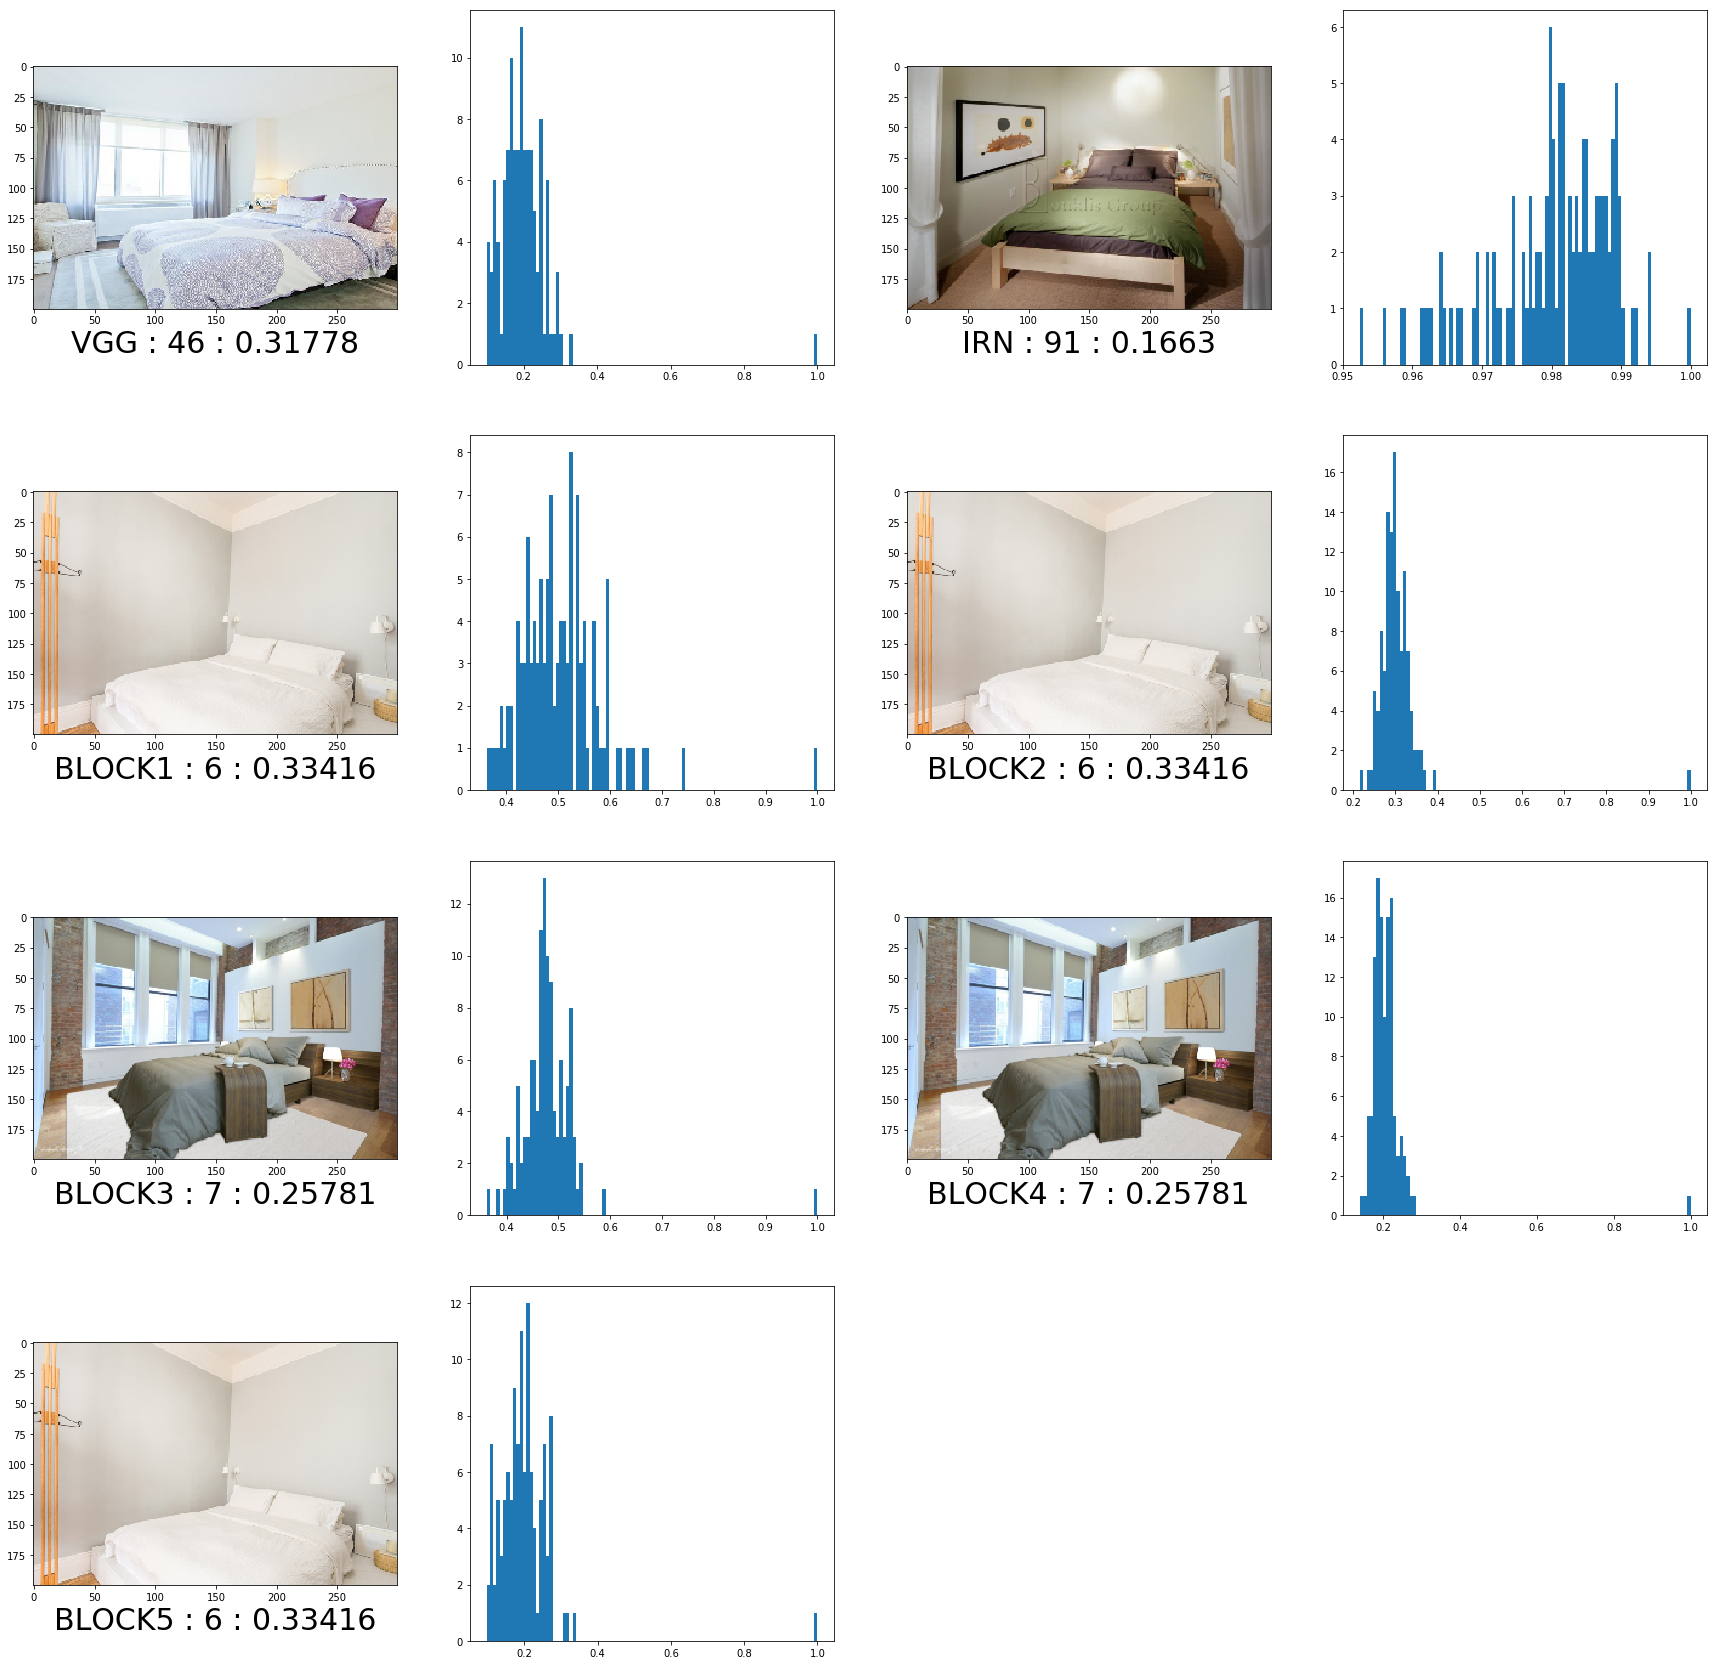

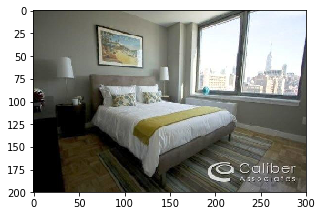

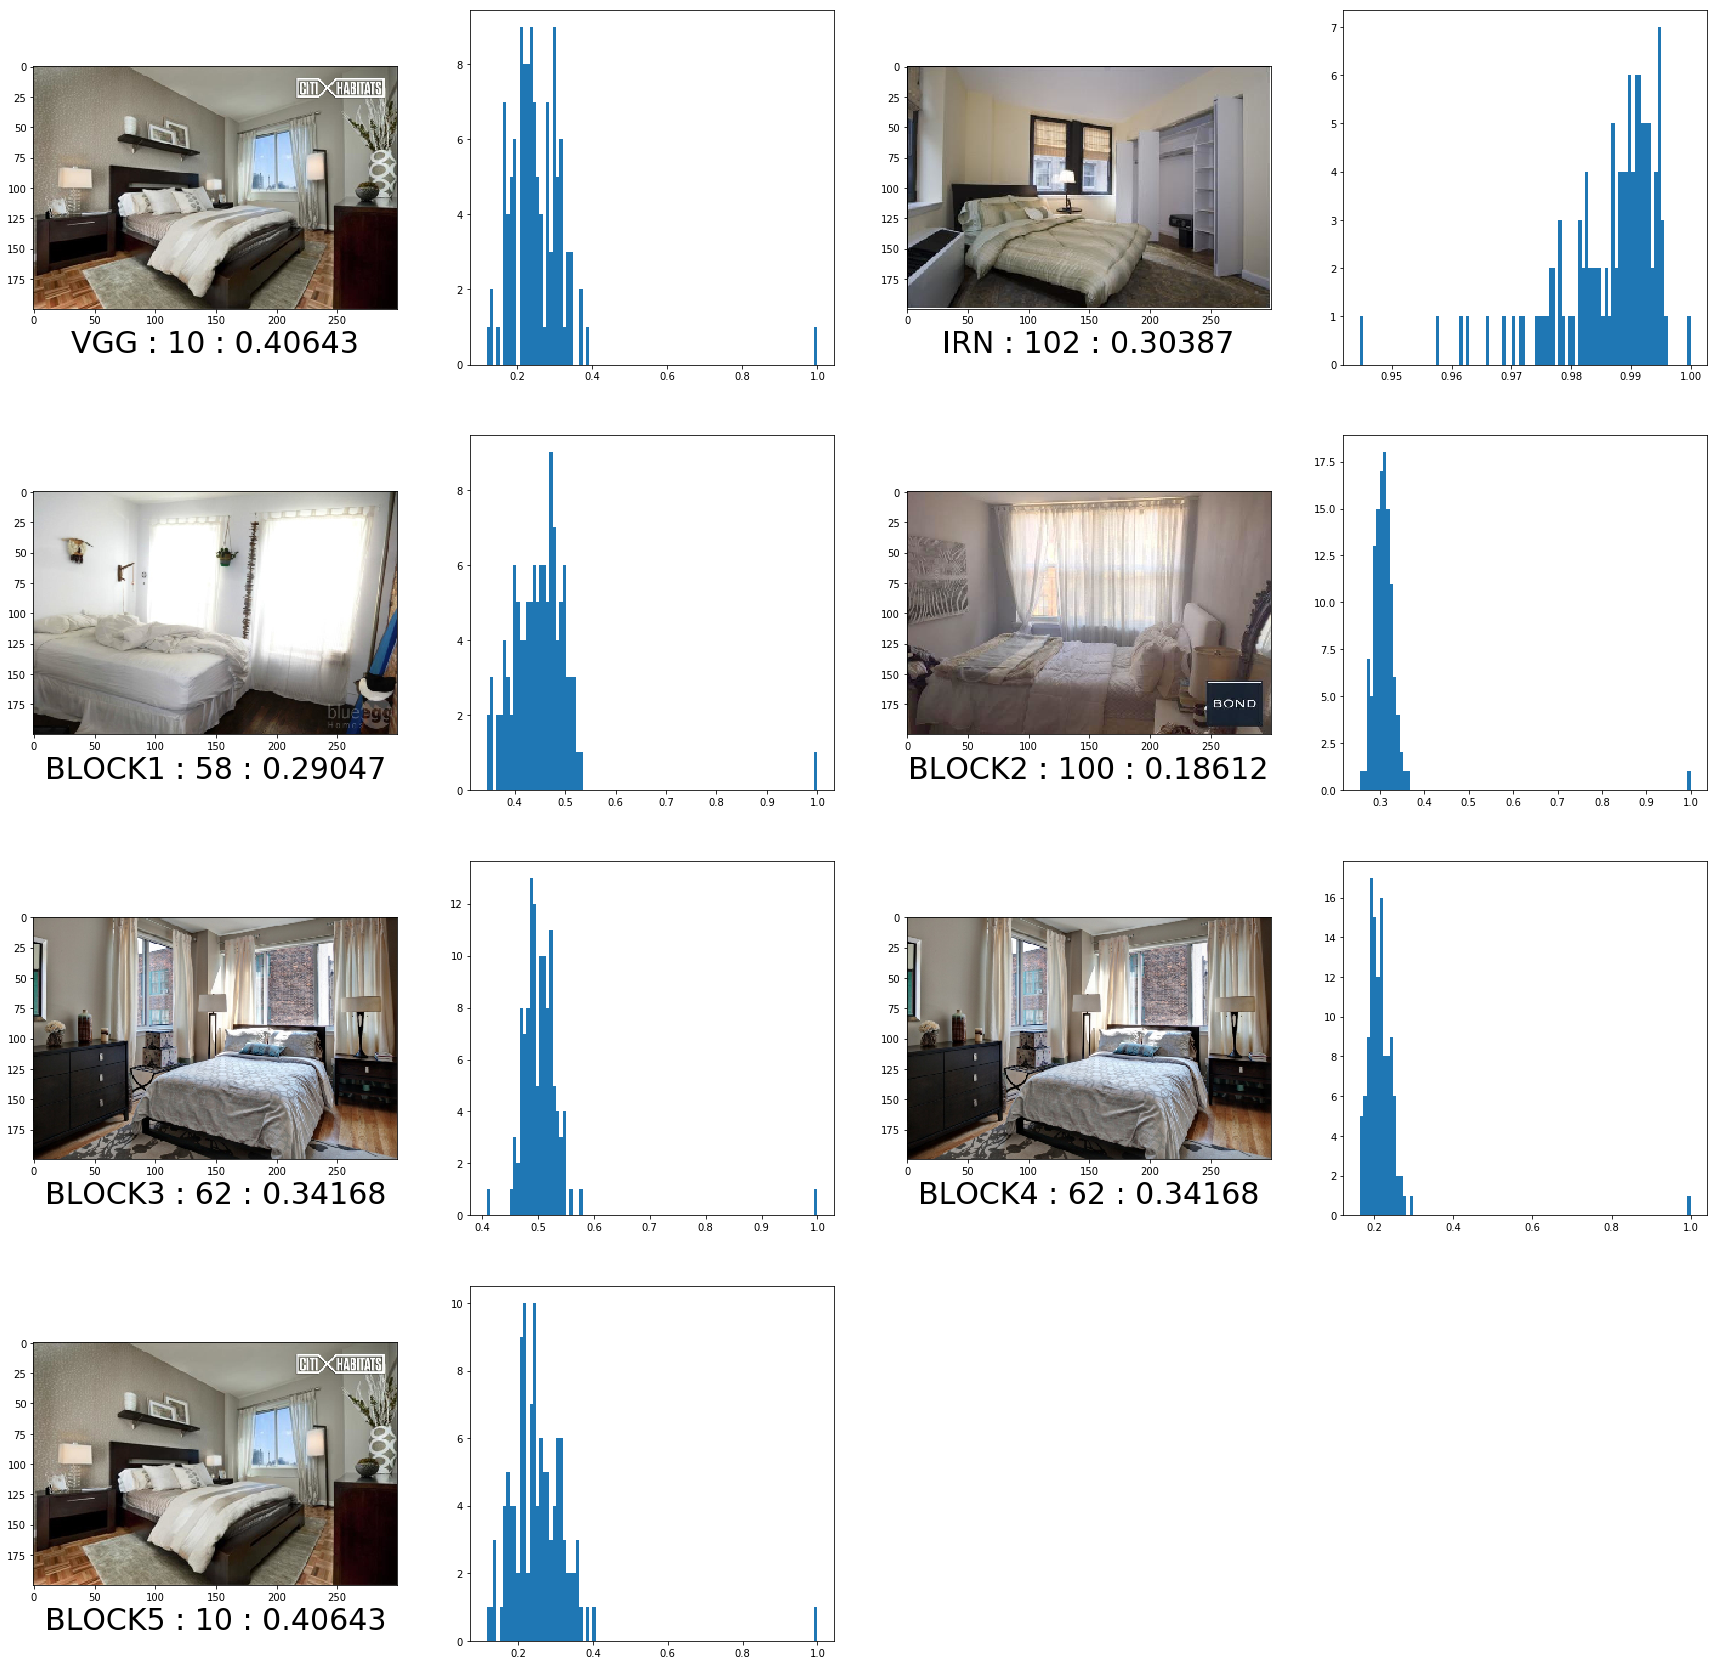

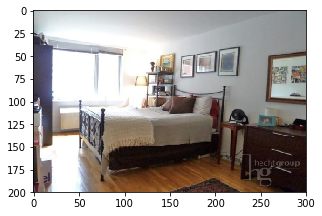

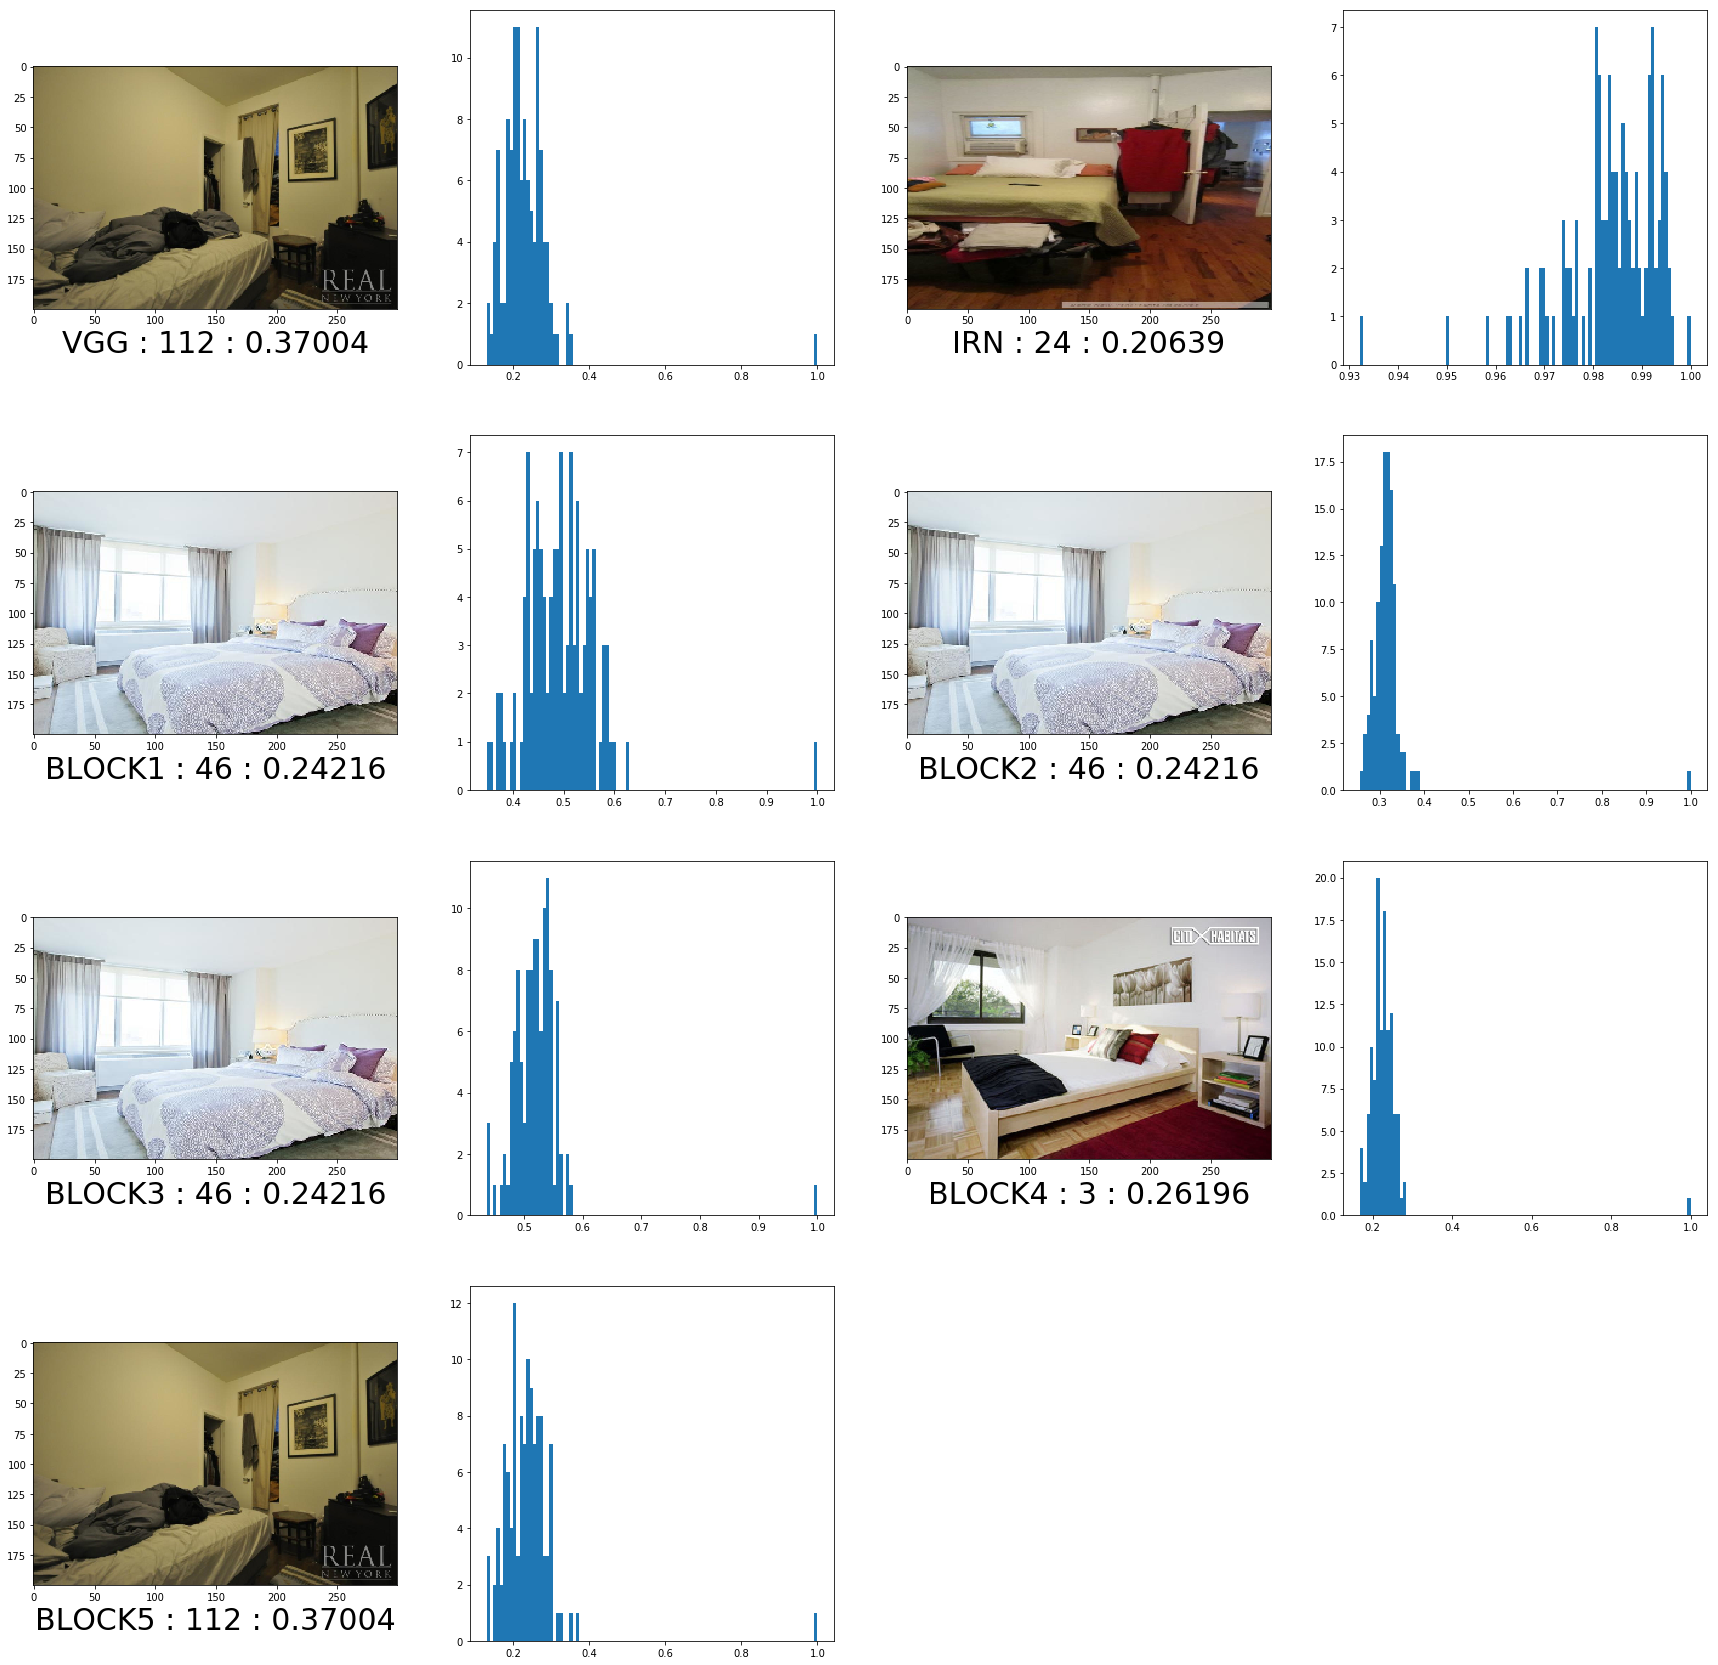

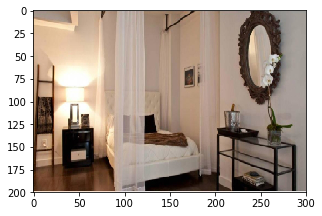

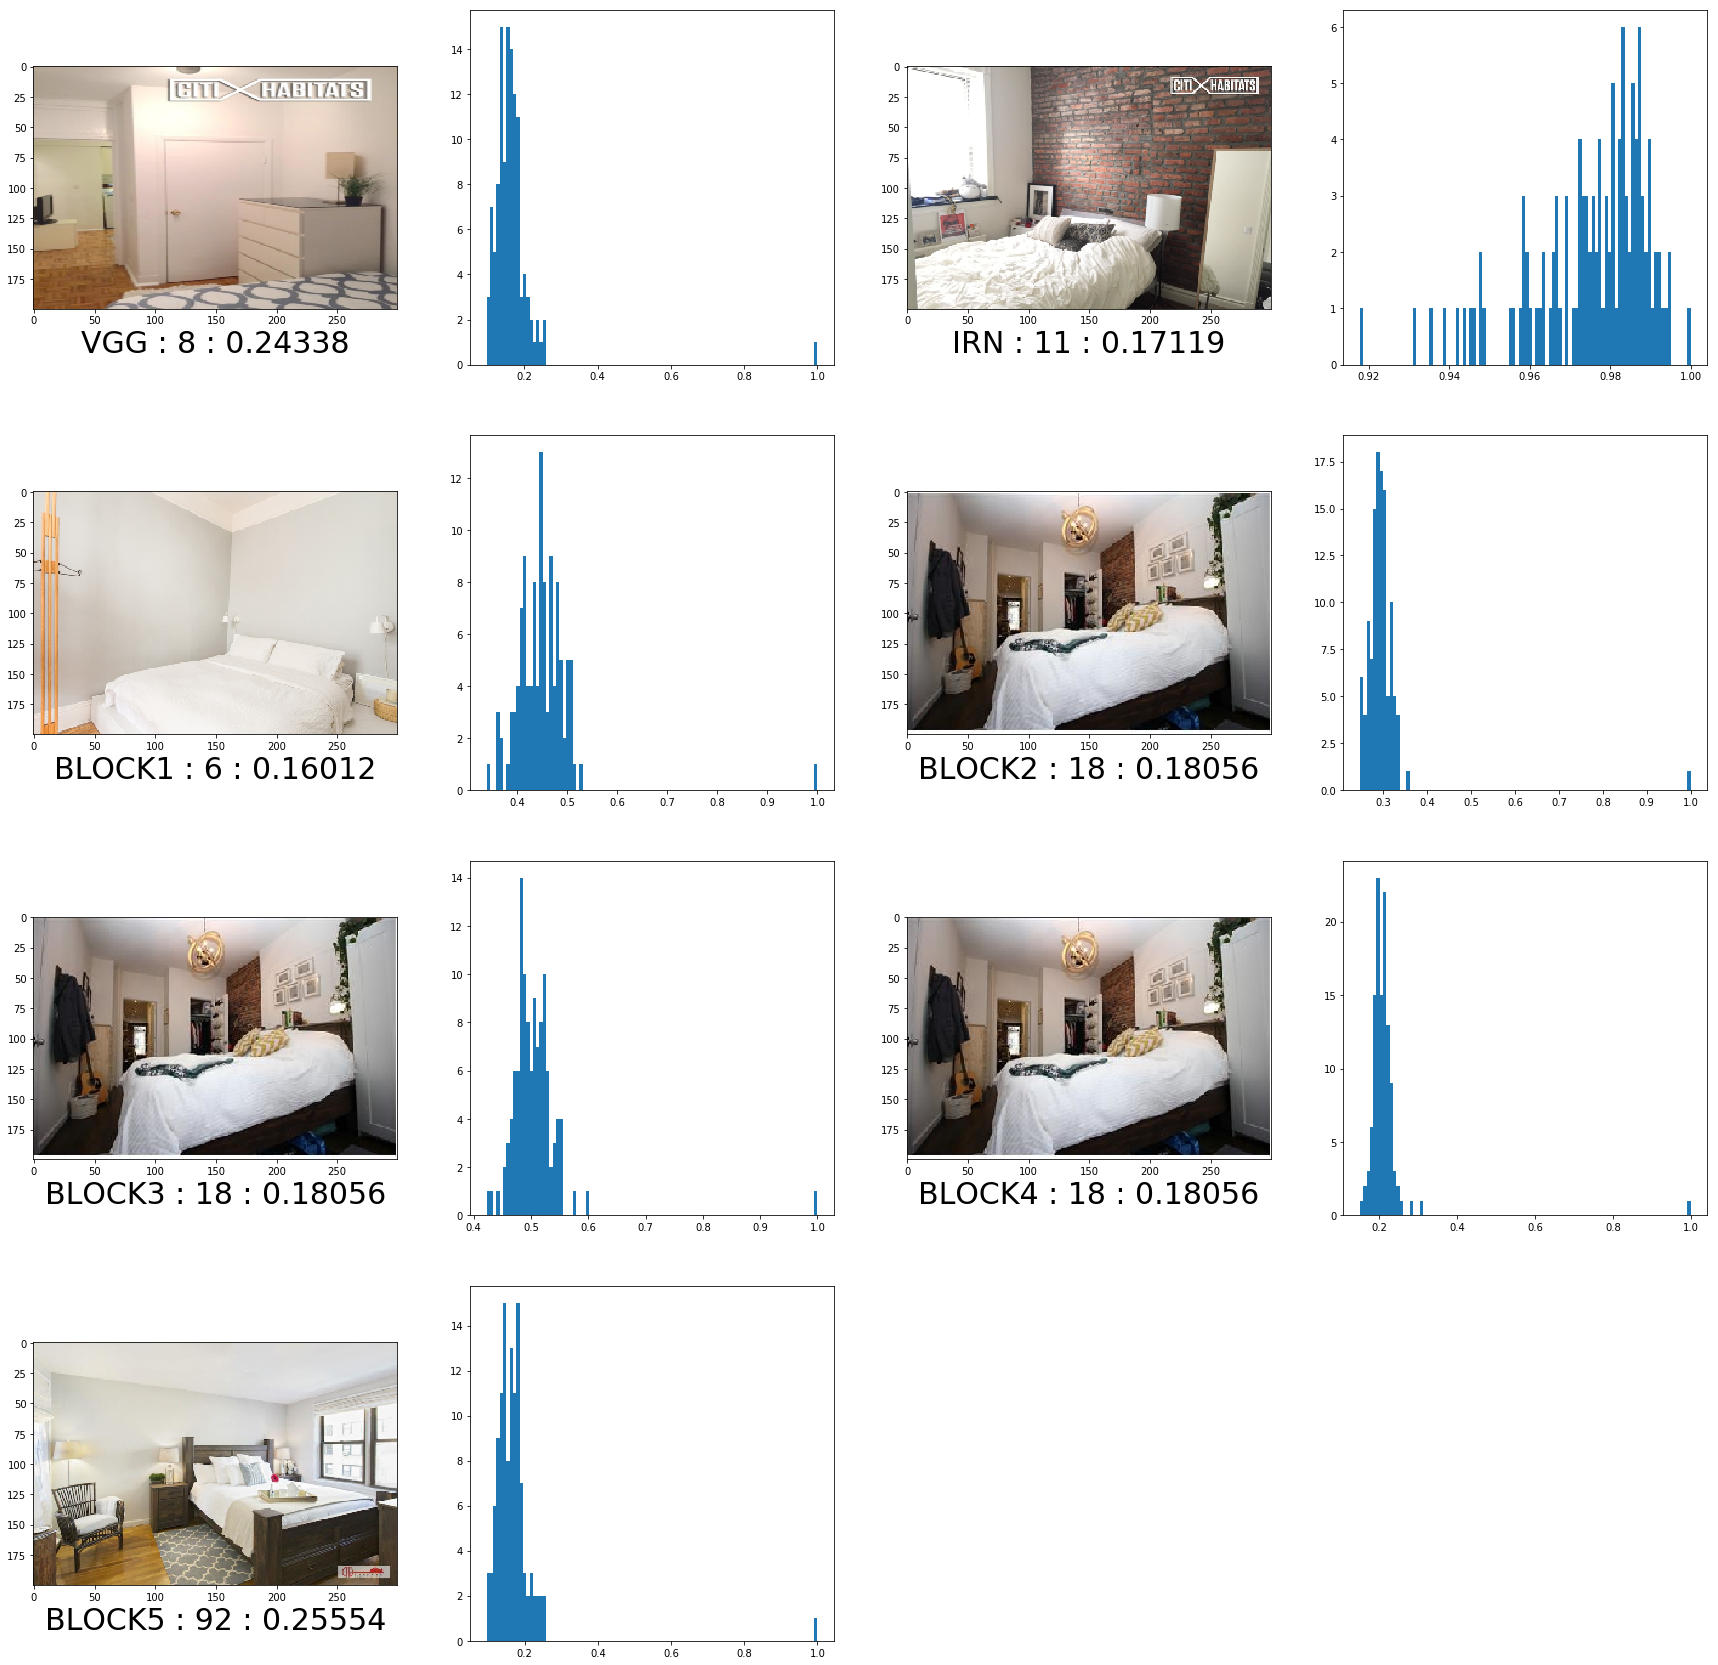

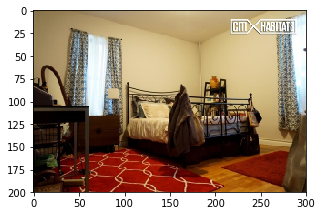

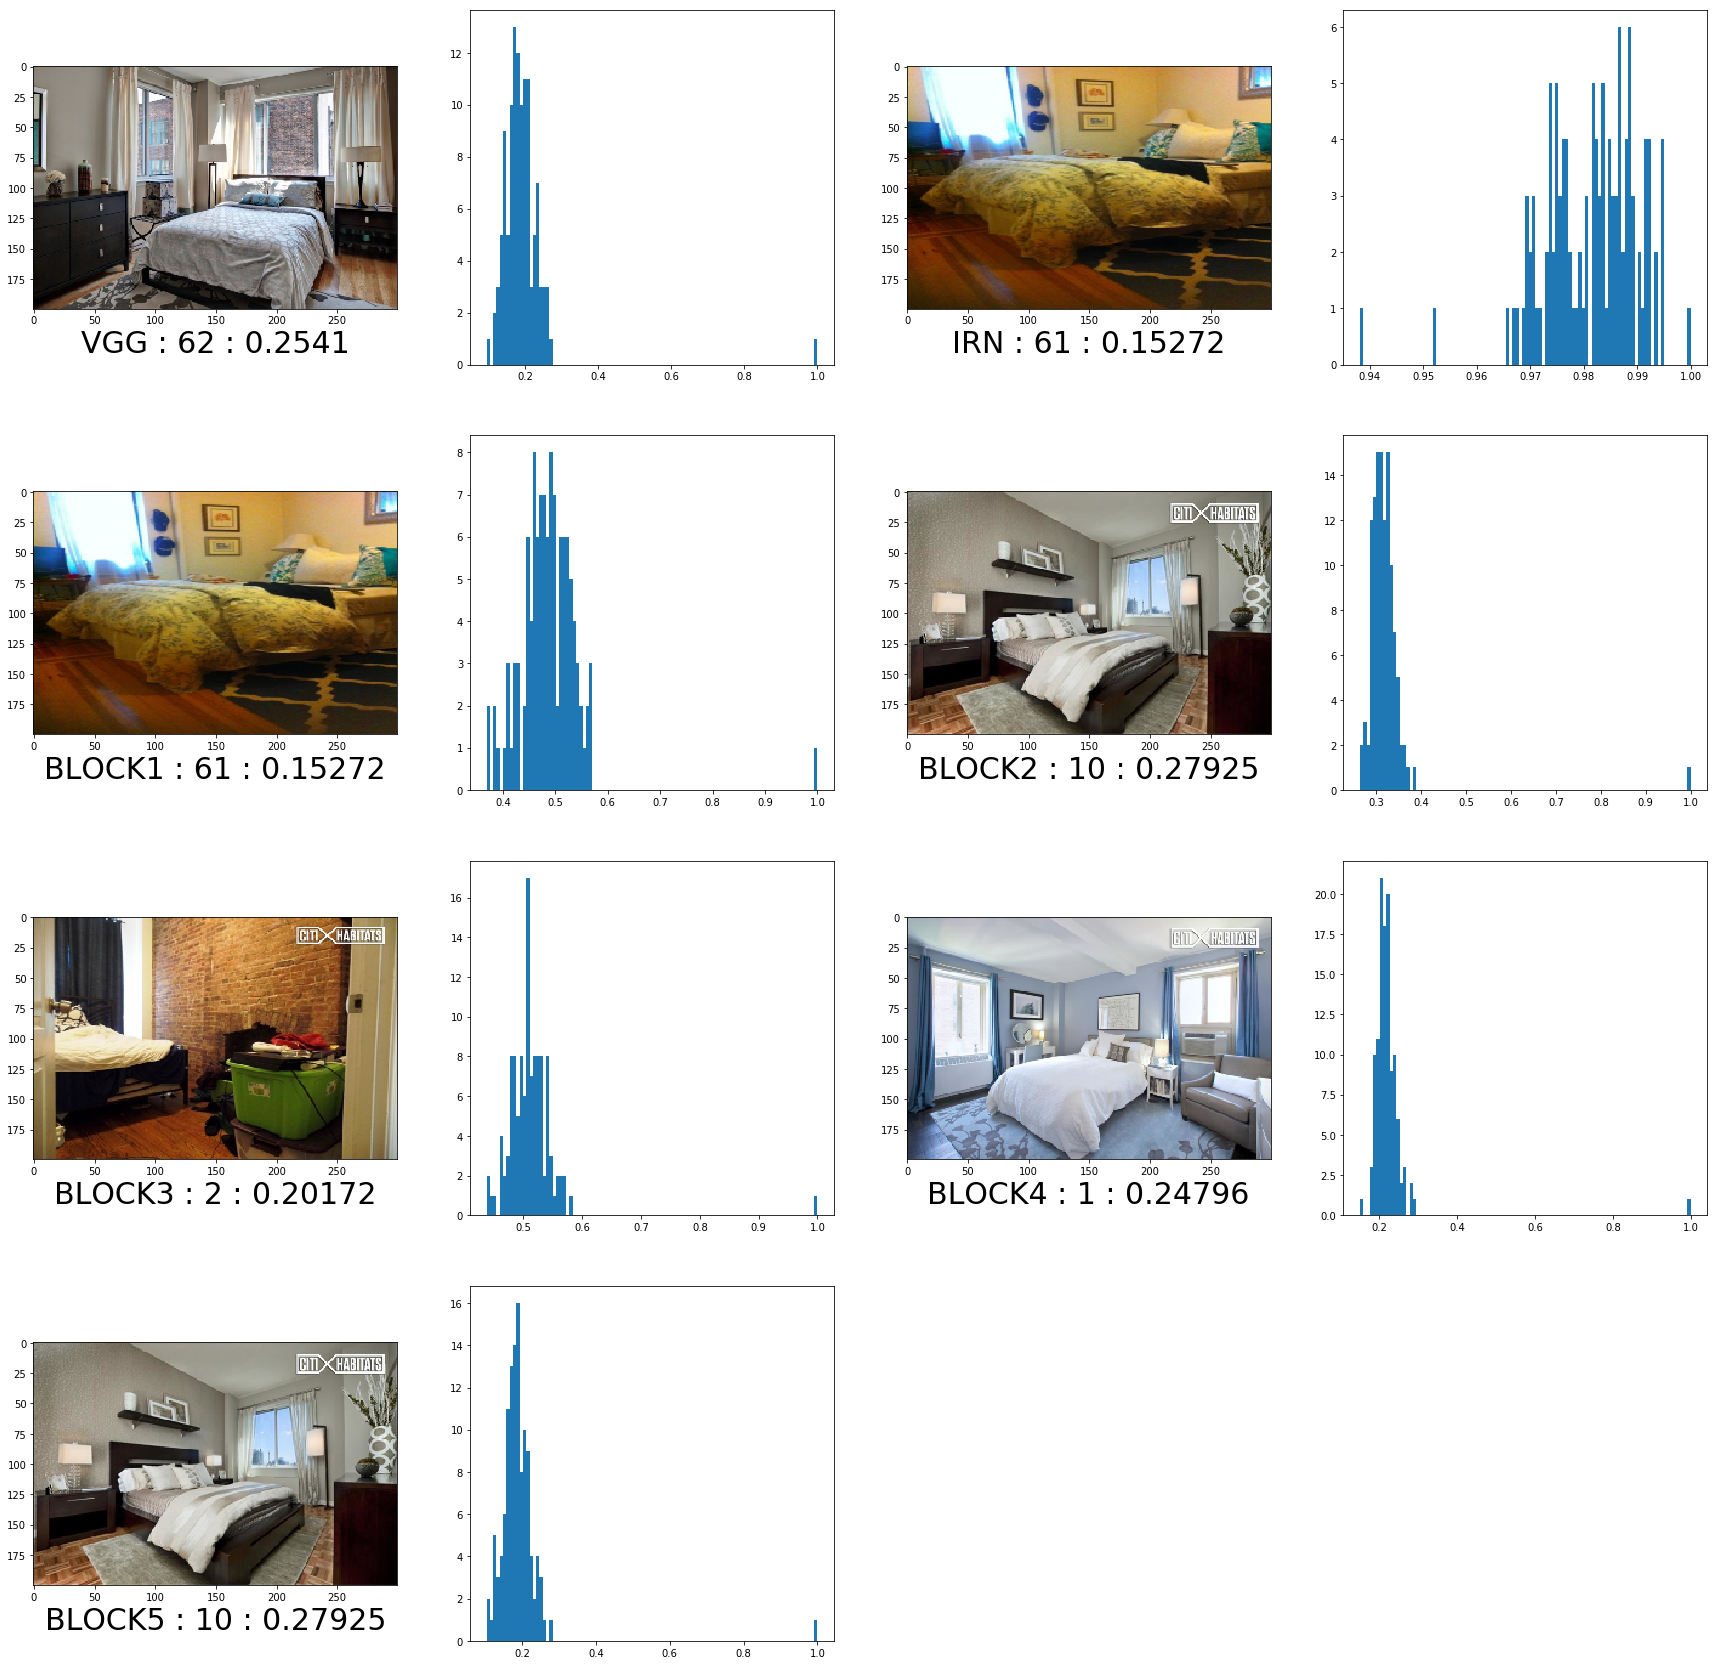

In [78]:
for i in selection:
    similar_img_comparison(i,comparison_set, bedrooms_viz,show_sim = True)

## comparison - heatmap

In [80]:
import seaborn as sns

In [131]:
def comparison_heatmap(sim_mat_set, vmin = 0, vmax = 1):
    
    n = len(sim_mat_set.keys())
    col = 4
    if n%2 == 0:
        row = n/2
    else:
        row = n//2 + 1
        
    plt.figure(figsize=(30,30))
    i = 1
    for key,value in comparison_set.items():
        ax = plt.subplot(row,col, i//col*col+i%col)
        sns.heatmap(value, vmin = vmin, vmax=vmax, square=True)
        ax.set_xlabel(key, fontsize = 20)
        i+=1

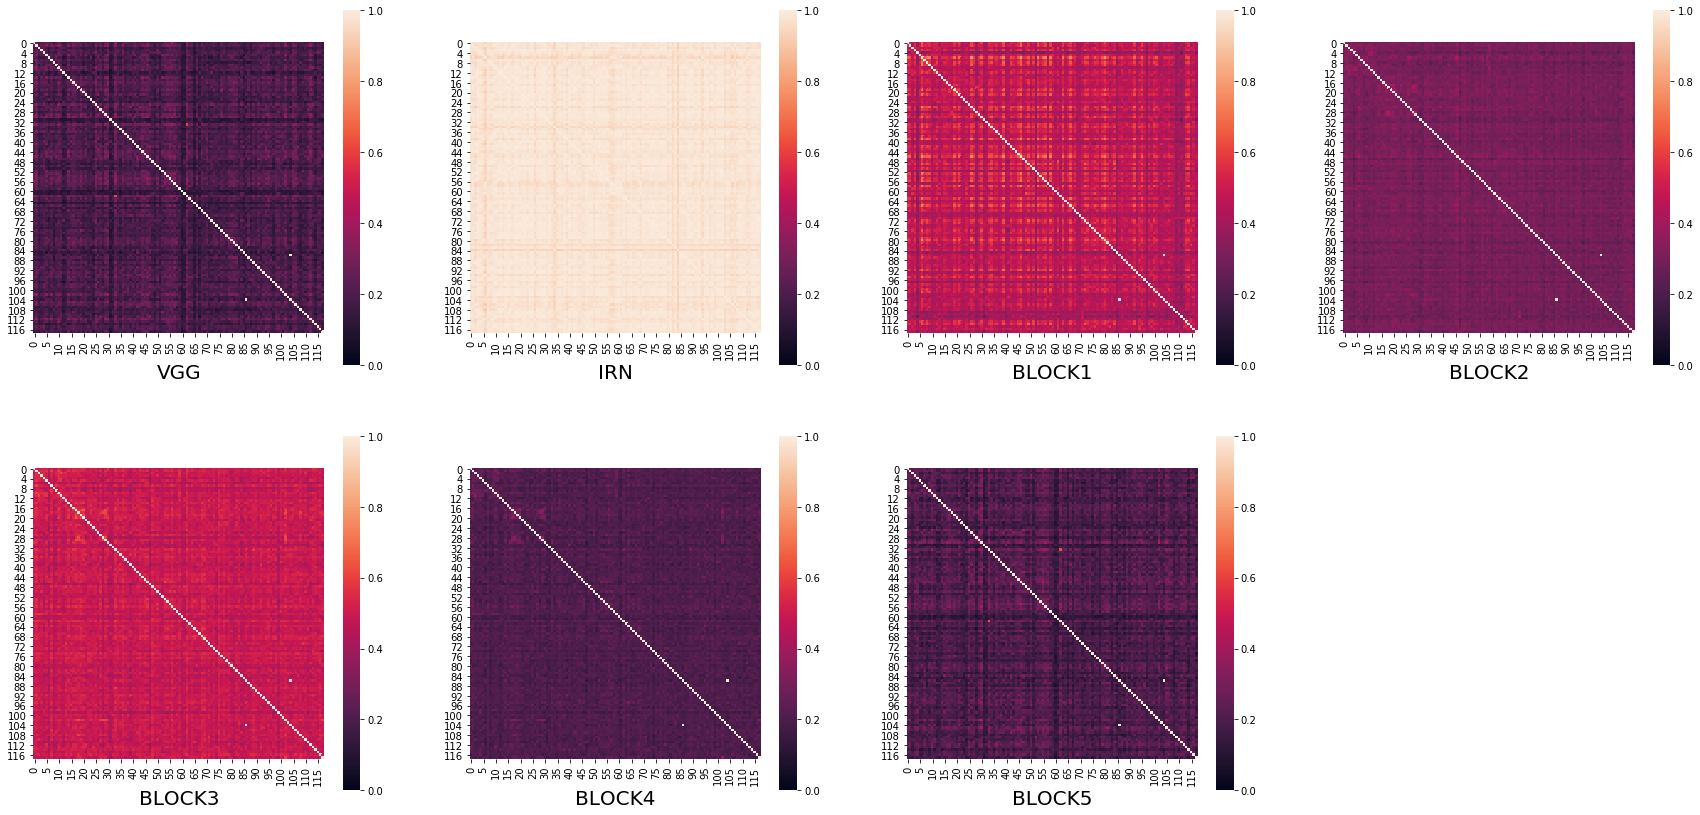

In [132]:
comparison_heatmap(comparison_set)